In [ ]:
import numpy as np 
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import pairwise_distances
from sklearn.model_selection import train_test_split


In [ ]:
#Reading data 

(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.mnist.load_data()

#samples = X_train[:2000].astype('float32') / 255 
#samples = samples.reshape(samples.shape[0], -1)

X_samples, X_test, y_samples, y_test = train_test_split(X_train, Y_train, train_size = .1)
X_samples = X_samples.reshape(X_samples.shape[0], -1) / 255

11501568/11490434 [==============================] - 0s 0us/step


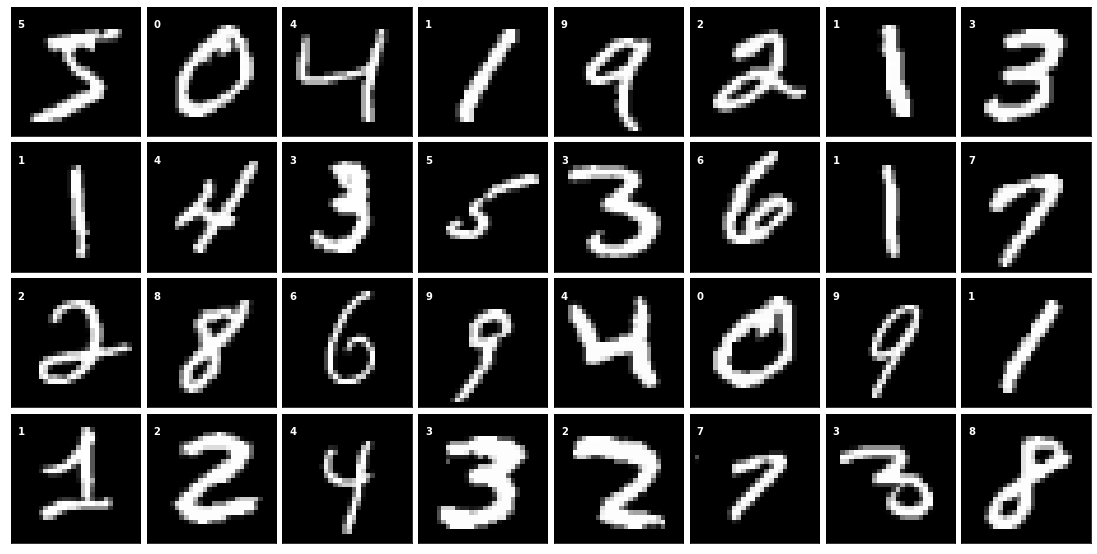

In [ ]:
#Plotting the images
fig = plt.figure(figsize = (15, 15))

fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = .05, wspace = 0.05)

for i in range(32):
    ax = fig.add_subplot(8, 8, i+1, xticks = [], yticks = [])
    ax.imshow(X_train[i], cmap = 'gray', interpolation = 'nearest')
    ax.text(1, 4, str(Y_train[i]), c = 'white', weight = 'bold')

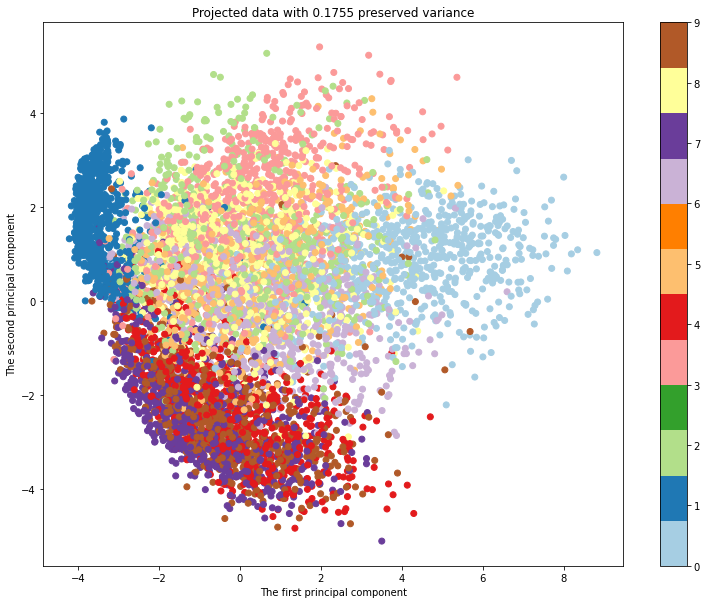

In [ ]:
#Performing PCA on test data so as to reduce our image dimensions for visualization purposes 
Samples = X_train[:7000].astype('float32') / 255

#Converting our 2 dimansional array to 1 dimansional array
X_1d = Samples.reshape(Samples.shape[0], 28*28)

pca = PCA(n_components = 2)
X_projected = pca.fit_transform(X_1d)
preserved_variance = pca.explained_variance_ratio_[0] + pca.explained_variance_ratio_[1]

plt.figure(figsize = (13, 10))
plt.scatter(X_projected[:, 0], X_projected[:, 1], c = Y_train[:7000], cmap = 'Paired')
plt.colorbar()
plt.xlabel('The first principal component')
plt.ylabel('The second principal component')
plt.title('Projected data with {:.4f} preserved variance'.format(preserved_variance))
plt.show()

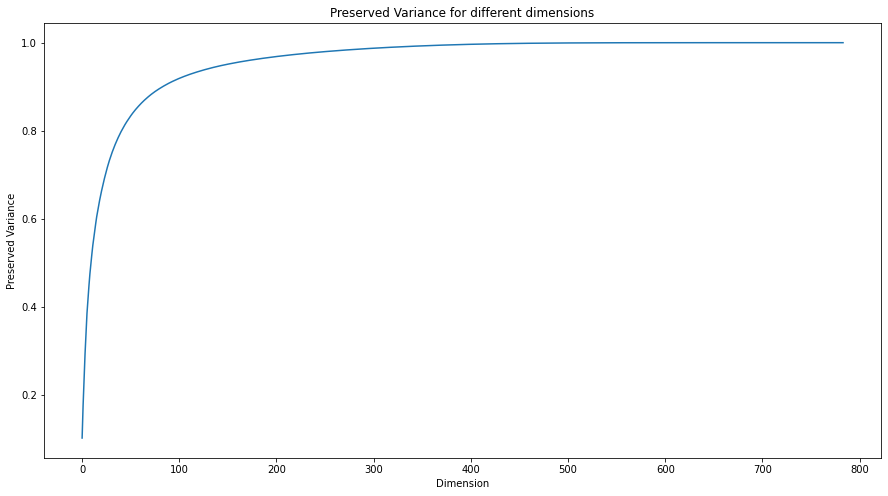

In [ ]:
pca2 = PCA(n_components = 784)
X_projected = pca2.fit_transform(X_1d)


cumsum = np.cumsum(pca2.explained_variance_)
summ = np.sum(pca2.explained_variance_)

plt.figure(figsize = (15, 8))
plt.plot(cumsum/summ)
plt.xlabel('Dimension')
plt.ylabel('Preserved Variance')
plt.title('Preserved Variance for different dimensions')
plt.show()

In [ ]:
from sklearn.metrics import pairwise_distances


def calc_distance(X):
	'''Returns a matrix of size N*N '''

	distances  = pairwise_distances(X)
	return -np.square(distances)


def softmax(distances):
    '''returns a matrix of e to the power of distances and 
    normalizes each row so that they add up to one'''

    e_x = np.exp(distances)
    np.fill_diagonal(e_x, val = 0)

    sum_of_rows = np.sum(e_x, axis = 1)
    sum_of_rows.shape = (distances.shape[0], 1) #N*1 column vector
    
    e_x = e_x + 1e-10 #Numerical Stability
    return e_x/sum_of_rows



class Tsne():

    def __init__(self, dim = 2, perplexity = 30, learning_rate = 10, momentum = 0.9, num_iters = 200, early_exaggeration = 30, 
                pca_dim = 60):
        self.dim = dim 
        self.perplexity = perplexity
        self.learning_rate = learning_rate
        self.momentum = momentum 
        self.num_iters = num_iters 
        self.early_exaggeration = early_exaggeration 
        self.pca_dim = pca_dim



    def _calc_prob_matrix(self, distances, sigma):
        ''' Just divides by sigma
        returns a matrix of conditiona probabilities divided by sigma'''

        sigma = 2 * np.square(sigma.reshape([-1, 1]))
        return softmax(distances/sigma)



    def _calc_perplexity(self, prob_matrix):
        '''Calculate the perplexity of each row
        of a matrix of probabilities.'''

        entropy = -np.sum(prob_matrix * np.log2(prob_matrix), 1)
        perplexity = 2 ** entropy
        return perplexity



    def _perplexity(self, distances, sigmas):
        '''First Component of Chain
        Wrapper function for quick calculation of
        perplexity over a distance matrix.'''

        return self._calc_perplexity(self._calc_prob_matrix(distances, sigmas))



    def _binary_search(self, eval_fn, target, tol = 1e-10, max_iter = 10000, lower = 1e-20, upper = 1500):
        ''' Second Component of Chain'''
        
        for i in range(max_iter):
            guess = (lower + upper) / 2.
            val = eval_fn(guess)
            if val > target:
                upper = guess
            else:
                lower = guess
            if np.abs(val - target) <= tol:
                break

        return guess



    def _find_sigma(self, distances, target_perplexity):
        ''' Third Component of Chain'''
        sigmas = []

        for i in range(distances.shape[0]):
            # calculate the perplexity of this row given sigma
            eval_fn = lambda sigma: self._perplexity(distances[i:i+1, :], np.array(sigma))
            
            # Binary search over sigmas to achieve target perplexity
            correct_sigma = self._binary_search(eval_fn, target_perplexity)
            
            # Append the resulting sigma to our output array
            sigmas.append(correct_sigma)


        return np.array(sigmas)


    def _p_conditional_to_joint(self, P):
        '''Given conditional probabilities matrix P, return
        approximation of joint distribution probabilities '''

        return (P + P.T) / (2. * P.shape[0])


    def _q_probs(self, Y):
        '''Given low-dimensional representations Y, compute
        matrix of joint probabilities with entries q_ij.'''

        distances = calc_distance(Y)
        inv_distances = np.power(1. - distances, -1)
        np.fill_diagonal(inv_distances, 0.)

        return inv_distances / np.sum(inv_distances), inv_distances



    def _p_joint(self, X, target_perplexity):
        '''Given a data matrix X, gives joint probabilities matrix.
        X: Input data matrix.

        target_perplexity: Specified by user

        # Returns:
            P: Matrix with entries p_ij = joint probabilities.
        '''

        distances = calc_distance(X)

        # Finding optimal sigma for each row of this distances matrix
        sigmas = self._find_sigma(distances, target_perplexity)

        # Calculating the probabilities based on these optimal sigmas
        p_conditional = self._calc_prob_matrix(distances, sigmas)

        P = self._p_conditional_to_joint(p_conditional)

        return P



    def _tsne_grad(self, P, Q, Y, distances):
        '''Computing the gradient of the cost with respect to Y.'''

        pq_diff = P - Q  # NxN matrix
        pq_expanded = np.expand_dims(pq_diff, 2)  # NxNx1
        y_diffs = np.expand_dims(Y, 1) - np.expand_dims(Y, 0)  # NxNx2

        # Expand our distances matrix so that we can multiply it by y_diffs
        distances_expanded = np.expand_dims(distances, 2)  # NxNx1----> this is the inverse of distances in the gradient

        # Multiply this (NxNx2) by distances matrix (NxNx1)
        y_diffs_wt = y_diffs * distances_expanded  # NxNx2
        grad = 4 * (pq_expanded * y_diffs_wt).sum(1)  # Nx2

        return grad



    def fit_transform(self, X):
        kl = []

        #Sampling initial Y
        Y = np.random.normal(0., 0.0001, [X.shape[0], self.dim])     
        X = PCA(n_components = self.pca_dim).fit_transform(X) 

        P = self._p_joint(X, self.perplexity)   
        P = P * 4 if self.early_exaggeration else P #early exaggeration

        # Initialise past values (used for momentum)
        if self.momentum:
            Y_m2 = Y.copy()
            Y_m1 = Y.copy()

        # Start gradient descent loop
        for i in range(self.num_iters):

            if i + 1 == self.early_exaggeration: 
                P = P/4 

            # Get Q and distances 
            Q, distances = self._q_probs(Y)
            Q = np.maximum(Q, 1e-12)

            if i % 250 == 0:
                self.learning_rate = self.learning_rate * 2

            # Estimate gradients with respect to Y
            grads = self._tsne_grad(P, Q, Y, distances)


            # Update Y
            Y = Y - (self.learning_rate * grads)
            if self.momentum:  # Add momentum
                if i >= 1000: #adaptive momentum
                    self.momentum = .7
                Y += self.momentum * (Y_m1 - Y_m2)


                # Update previous Y's for momentum
                Y_m2 = Y_m1.copy()
                Y_m1 = Y.copy()

            if (i+1) % 100 == 0:
                C = np.sum(P * np.log(P / Q))
                print('In Iteration: {},  KL-divergence is: {:.4f}'.format(i + 1, C))
                kl.append(C)
       
        return Y, kl 



In [ ]:
tsne = Tsne(dim = 2, learning_rate = 100, perplexity = 30, early_exaggeration = 50, pca_dim = 30, num_iters = 1000, momentum = .7)
Y, kl = tsne.fit_transform(X_samples)



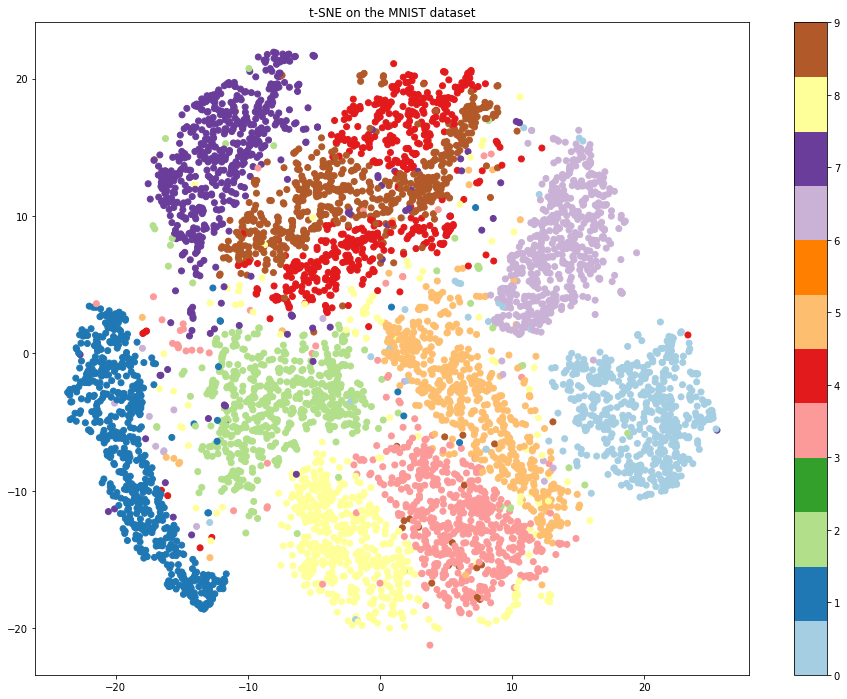

In [ ]:
# Ploting the low-dimensional Data (Optimal)

plt.figure(figsize = (16, 12))
plt.scatter(Y[1:, 0], Y[1:, 1], c = y_samples[1:], cmap = 'Paired')
plt.colorbar()
plt.title('t-SNE on the MNIST dataset')
plt.savefig('mnist.png')
plt.show()



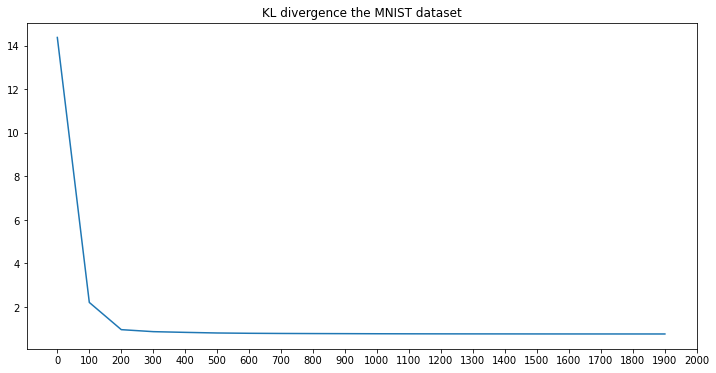

In [ ]:
ticks = ticks = [i for i in range(1, 2001, 100)]

plt.figure(figsize = (12, 6))

plt.plot(ticks, kl)

plt.title('KL divergence the MNIST dataset')
plt.xticks(ticks = [i for i in range(0, 2001, 100)])
plt.xlabel('iterations')
plt.ylabel('KL divergence')
plt.savefig('kl.png')
plt.show()


In [ ]:
#Example  1

X = np.array([[1.2563, 2.3254], [3.9365, 4.2548], [5.9854, 9.3641]])

dist = pairwise_distances(X)
z = np.expand_dims(X, 2)

Y1 = np.expand_dims(X, 1)
Y2 = np.expand_dims(X, 0)

out = Y1 - Y2

print(X, end = '\n')
print('\n')
print(Y1)
print(Y1.shape)
print('\n\n')
print(Y2)
print(Y2.shape)
print('\n\n')
print(out)
print(out.shape)

[[1.2563 2.3254]
 [3.9365 4.2548]
 [5.9854 9.3641]]


[[[1.2563 2.3254]]

 [[3.9365 4.2548]]

 [[5.9854 9.3641]]]
(3, 1, 2)



[[[1.2563 2.3254]
  [3.9365 4.2548]
  [5.9854 9.3641]]]
(1, 3, 2)



[[[ 0.      0.    ]
  [-2.6802 -1.9294]
  [-4.7291 -7.0387]]

 [[ 2.6802  1.9294]
  [ 0.      0.    ]
  [-2.0489 -5.1093]]

 [[ 4.7291  7.0387]
  [ 2.0489  5.1093]
  [ 0.      0.    ]]]
(3, 3, 2)


In [ ]:
#Example  2

c1 = np.random.randn(3, 3, 1)
c2 = np.random.randn(3, 3, 2)

out2 = c2 * c1

print(c2, 'C2')
print('\n')
print(c1, 'C1')
print('\n')
print(out2, 'Result')
print(np.sum(out2, axis = 1))


[[[-0.31953775  0.0328126 ]
  [ 0.09912665 -0.04987793]
  [ 1.17353354  0.494018  ]]

 [[ 1.58734195  0.49399527]
  [ 0.89649305  0.46615589]
  [ 0.63945974 -0.08854668]]

 [[ 1.53767807 -0.57803519]
  [ 0.73448945  0.13974784]
  [-0.69878888 -0.2819536 ]]] C2


[[[-0.78241832]
  [-0.82703184]
  [-0.38091632]]

 [[-0.26292495]
  [ 0.08683897]
  [ 0.45451231]]

 [[ 0.48545904]
  [-2.03199511]
  [ 0.30690518]]] C1


[[[ 0.25001219 -0.02567318]
  [-0.08198089  0.04125063]
  [-0.44701808 -0.18817952]]

 [[-0.4173518  -0.12988368]
  [ 0.07785053  0.04048049]
  [ 0.29064232 -0.04024556]]

 [[ 0.74647971 -0.28061241]
  [-1.49247897 -0.28396692]
  [-0.21446193 -0.08653302]]] Result
[[-0.27898678 -0.17260206]
 [-0.04885895 -0.12964874]
 [-0.96046119 -0.65111235]]
